# Plan
- step01(PASS) : deepseekocr로 table을 제외한 이미지 구역을 추출
- step02 : 이미지 구역에서 심볼을 기준으로 크롭하고 다음 단계로(sketch_detection_sysmbol_v1,v2)
- step03 :각 크롭한 이미지를 ocr로 텍스트 추출하기 : deepseekocr -> **다른 OCR**(tesseract, paddle)

### setting

In [3]:
import cv2, os
from symbol_region_splitter import match_symbol, split_and_extract_regions
from utils import visualize_detections, show_image_highres
# import pytesseract
from paddleocr import PaddleOCR

### 테스트할 도면과 저장 위치 지정
# image_file = '../data/hard_task_test01_v1.PNG'
image_file = '../data/easy_task_test05_v1.PNG'
output_path = './result_v2_paddle'
symbol_path = '../data/symbol_mini.PNG'

# Tesseract 설정
# tesseract_lang = 'kor+eng'  # 한글 + 영어
os.makedirs(output_path, exist_ok=True)


### step02-03

탐지된 심볼 수 (중복 제거 후): 1


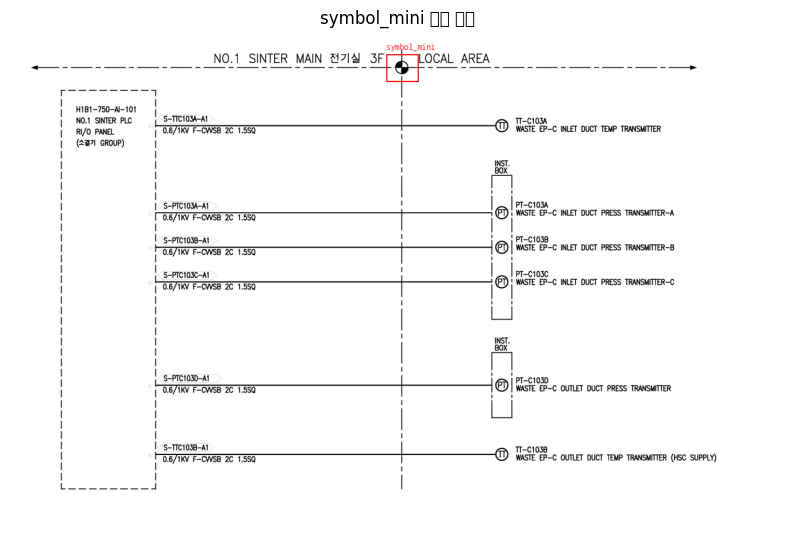

[2025/11/03 21:54:07] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/dibaeck/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/dibaeck/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_tex

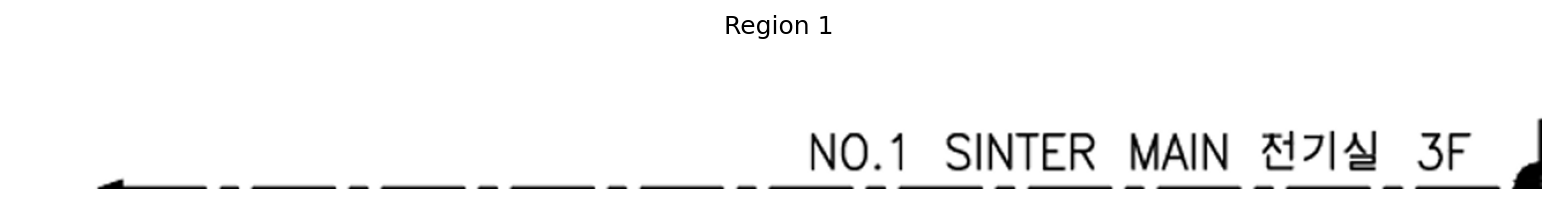

[2025/11/03 21:54:16] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2025/11/03 21:54:16] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03173351287841797
[2025/11/03 21:54:16] ppocr DEBUG: rec_res num  : 5, elapse : 0.05074000358581543
[OCR 완료] Region 1 → 22 chars
[Region 1] OCR 결과:
NO1
SINTER
MAIN
전기실
3F



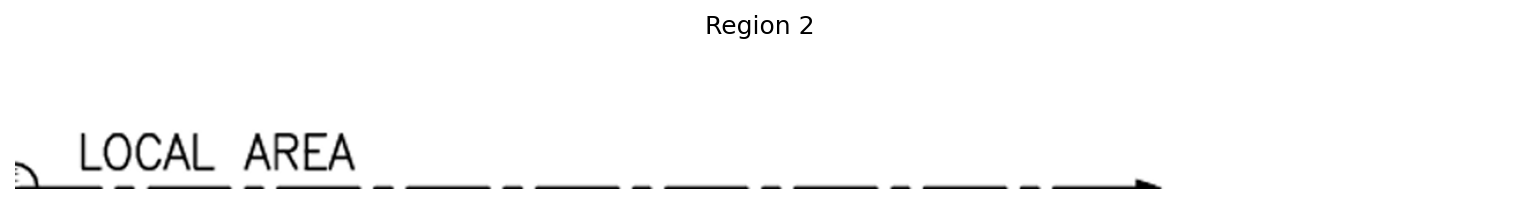

[2025/11/03 21:54:16] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2025/11/03 21:54:17] ppocr DEBUG: dt_boxes num : 2, elapse : 0.020796775817871094
[2025/11/03 21:54:17] ppocr DEBUG: rec_res num  : 2, elapse : 0.0308988094329834
[OCR 완료] Region 2 → 10 chars
[Region 2] OCR 결과:
LOCAL
AREA



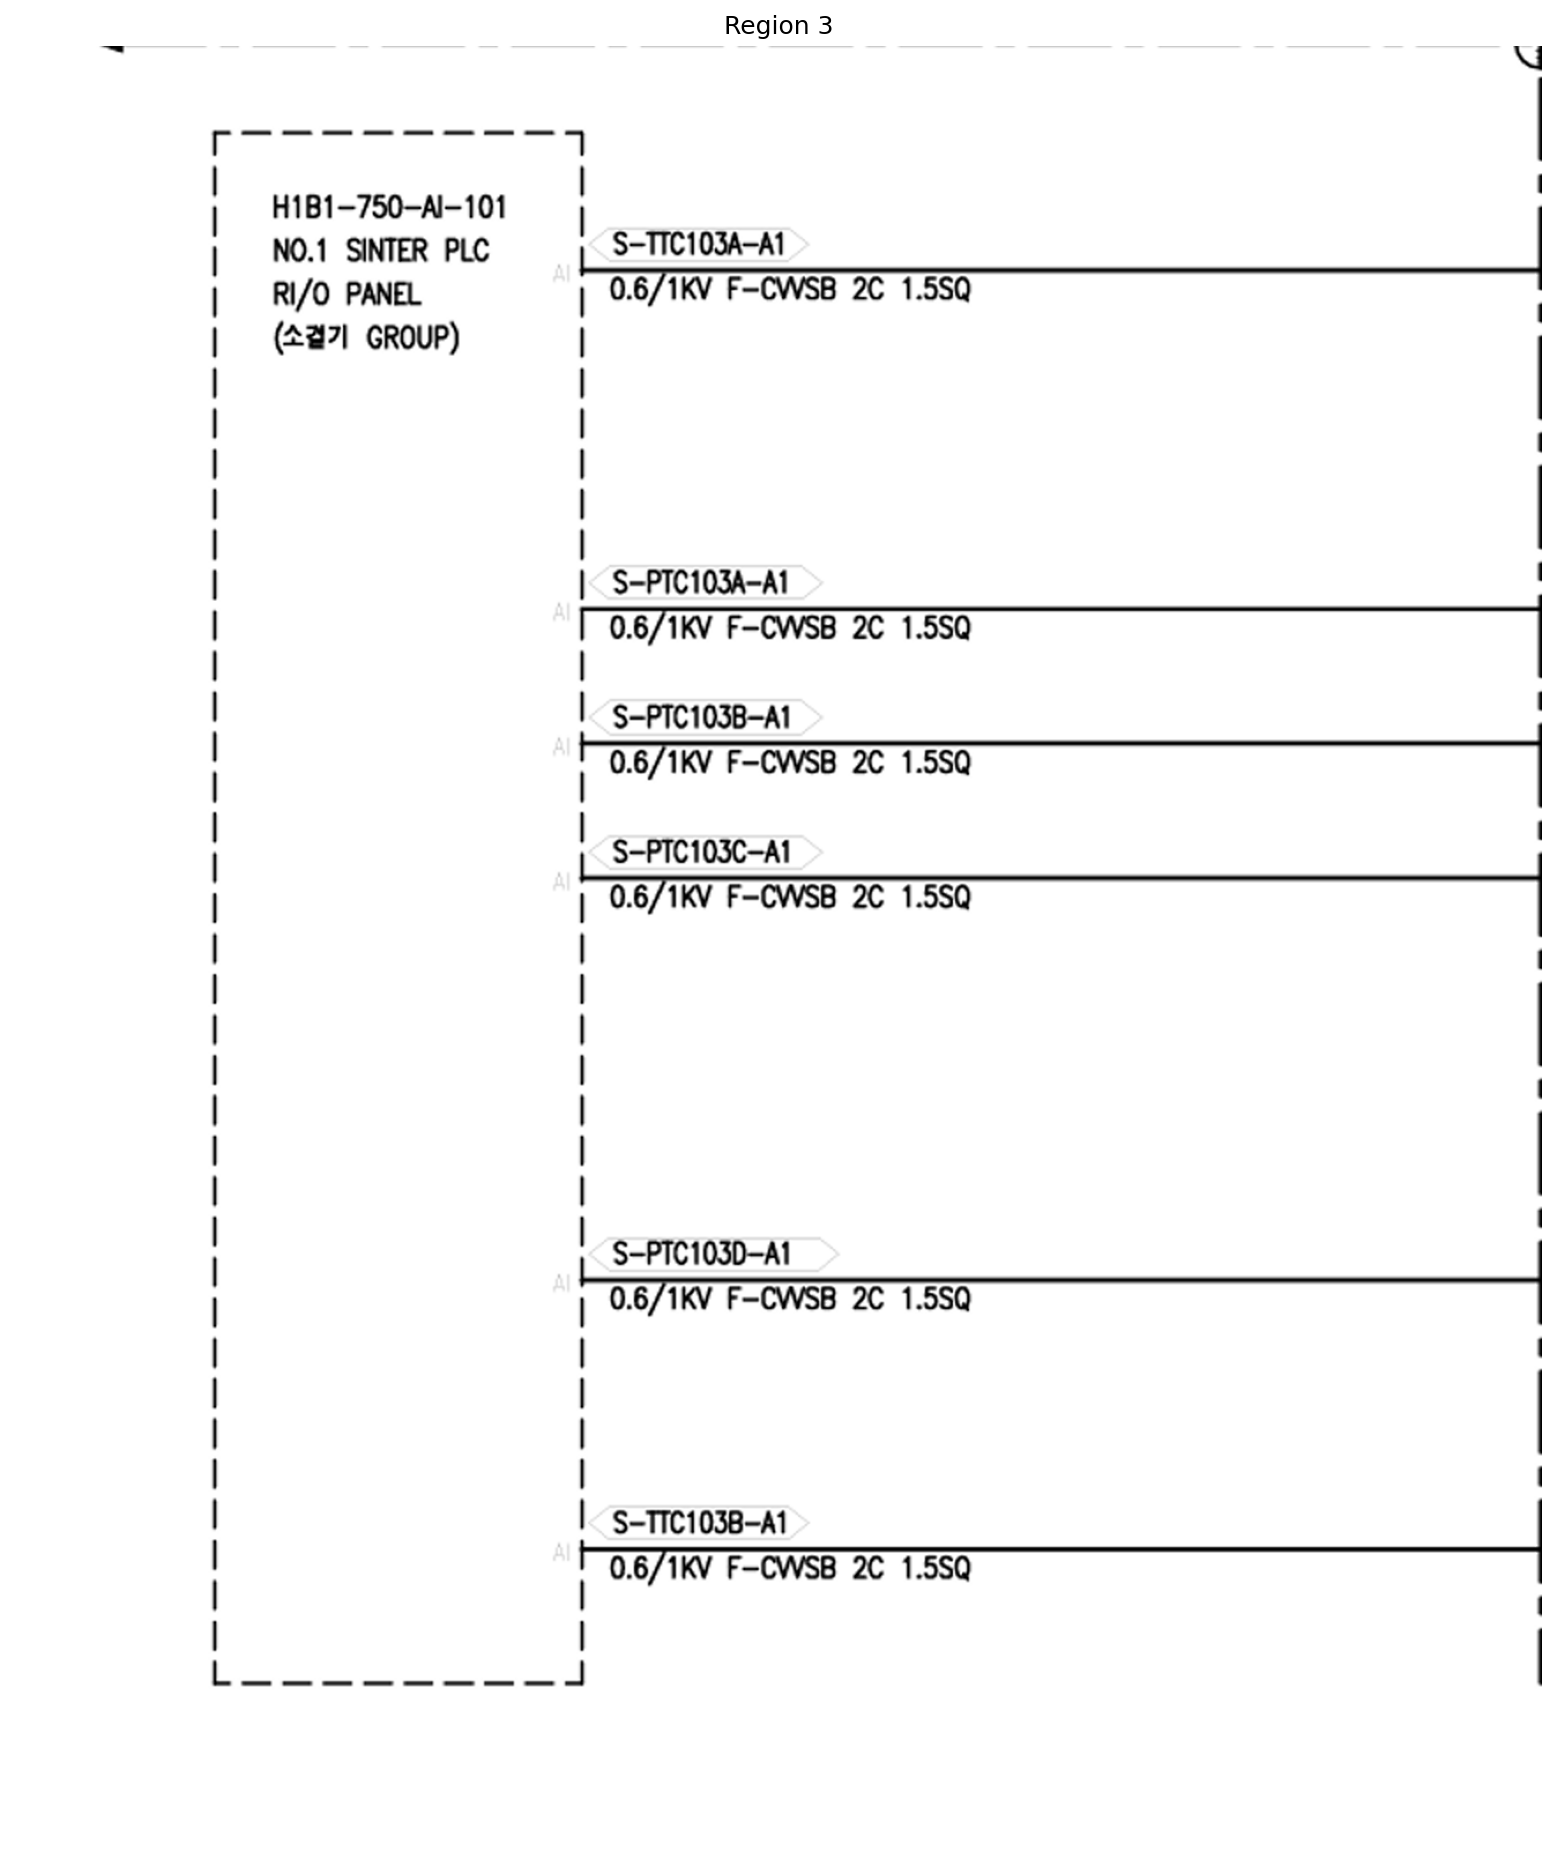

[2025/11/03 21:54:18] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2025/11/03 21:54:18] ppocr DEBUG: dt_boxes num : 38, elapse : 0.10426974296569824
[2025/11/03 21:54:18] ppocr DEBUG: rec_res num  : 38, elapse : 0.24829721450805664
[OCR 완료] Region 3 → 260 chars
[Region 3] OCR 결과:
H1B1-750-A-101
NO1
SINTER
PLC
S-TIC103A-A1
R/o
PANEL
06/1KV
F-CWSB
2C
15sQ
소결기
GROUP
S-PIC103A-A1
06/1KV
F-CWSB
2C
15sQ
S-PTC103B-A1
06/1KV
F-CWSB
2C
15s0
S-PIC103C-A1
06/1KV
F-CWSB
2C
15s0
S-PTc103D-A1
06/1KV
F-CWSB
2C
15s0
S-TIC1038-A1
O6/IKV
F--CWSB
2C
15sQ



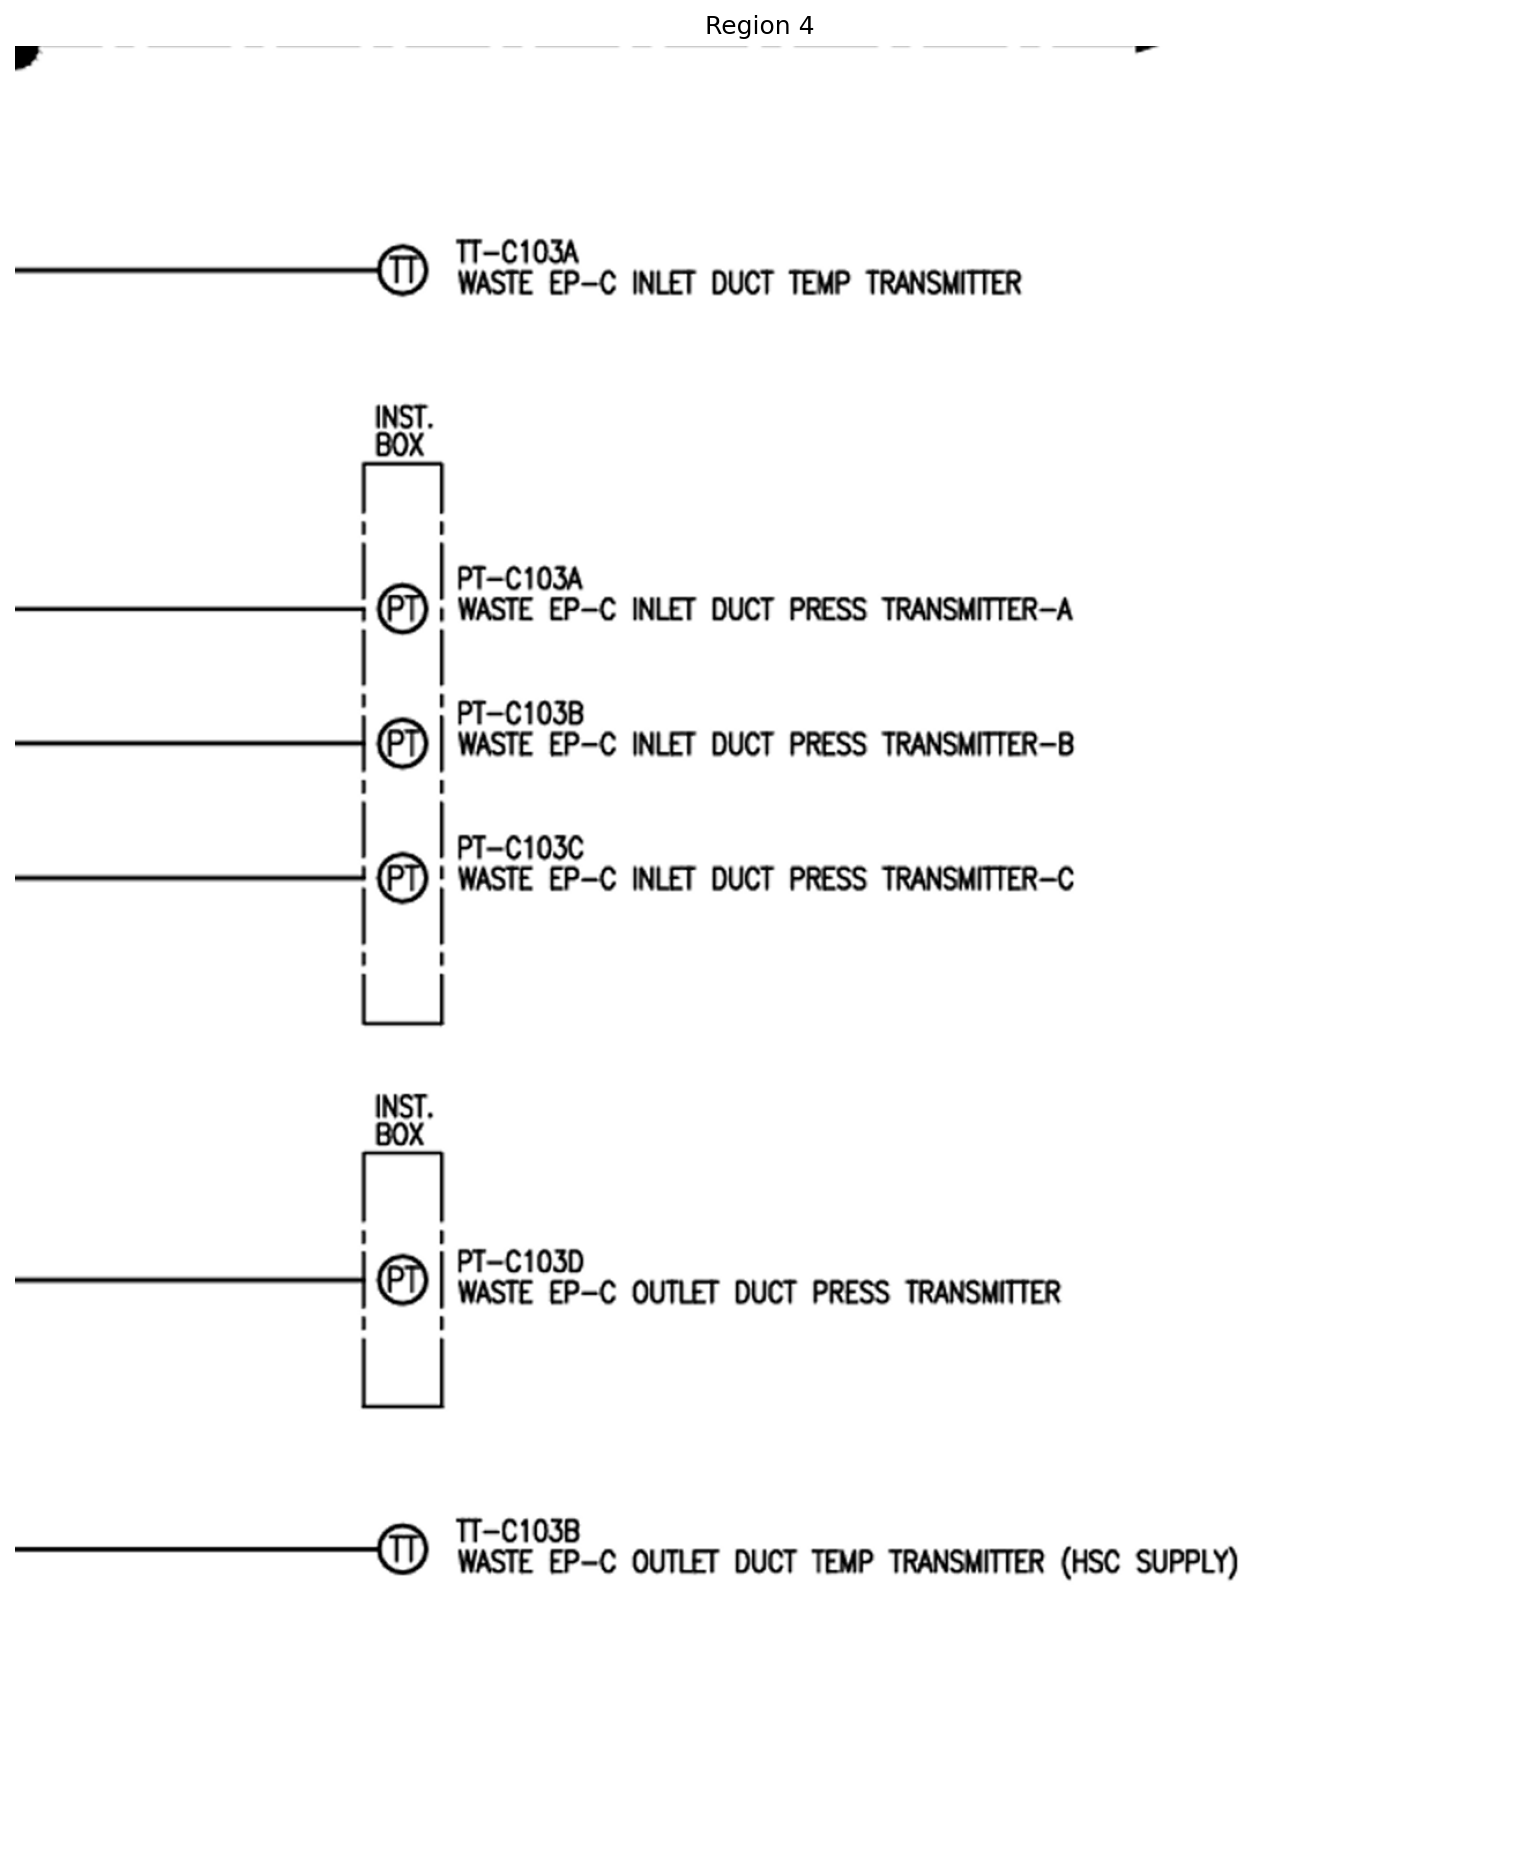

[2025/11/03 21:54:19] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2025/11/03 21:54:19] ppocr DEBUG: dt_boxes num : 48, elapse : 0.10033845901489258
[2025/11/03 21:54:20] ppocr DEBUG: rec_res num  : 48, elapse : 0.28841209411621094
[OCR 완료] Region 4 → 328 chars
[Region 4] OCR 결과:
TT-C103A
WASTE
Ep-c
INLET
DUCT
TEMP
TRANSMITTER
NST
BOX
PT-C103A
WASTE
EP-C
INLET
DUCT
PRESS
TRANSMITTER-A
PI-C103B
WASTE
Ep-c
INLET
DUCT
PRESS
TRANSMITTER--B
PT-c103C
WASTE
Ep-c
INLET
DUcT
PRESS
TRANSMITTER-C
INST
BOX
PT-C103D
WASTE
EP-C
OUTLET
DUCT
PRESS
TRANSMITTER
TI-C103B
WASTE
EP-c
OUTLET
DUCT
TEMP
TRANSMITTER
HSC
SUPPLY


✅ 모든 OCR 완료!


In [4]:
# 이미지 로드
drawing = cv2.imread(image_file)
if drawing is None:
    raise FileNotFoundError(f"도면을 찾을 수 없습니다: {image_file}")
drawing_gray = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY)

symbol_img = cv2.imread(symbol_path)
if symbol_img is None:
    raise FileNotFoundError(f"심볼 이미지를 찾을 수 없습니다: {symbol_path}")
symbol_gray = cv2.cvtColor(symbol_img, cv2.COLOR_BGR2GRAY)
symbol_name = os.path.splitext(os.path.basename(symbol_path))[0]


# 심볼 매칭 & 중복 제거 & 시각화
filtered_boxes = match_symbol(drawing_gray, symbol_gray, threshold=0.75)
visualize_detections(drawing, filtered_boxes, symbol_name)

# 중심 좌표 계산
centers_x = [(x1 + x2)//2 for (x1, y1, x2, y2) in filtered_boxes]
centers_y = [(y1 + y2)//2 for (x1, y1, x2, y2) in filtered_boxes]

# 영역 분할 & (off)확대 ROI 시각화
regions = split_and_extract_regions(drawing, centers_x, centers_y, fallback=20, zoom_factor=2.0)

# ROI 저장 및 OCR 수행
ocr_results = {}

# OCR 수행
ocr_results = {}
ocr_paddle = PaddleOCR(use_textline_orientation=True, lang='korean',device='gpu')           # use_angle_cls -> use_textline_orientation

for region_id, roi in regions:
    show_image_highres(roi, f"Region {region_id}", zoom=1.0, dpi=150)

    roi_file = os.path.join(output_path, f'roi_{region_id}.png')
    cv2.imwrite(roi_file, roi)

    # 빈 이미지 필터링
    if cv2.countNonZero(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)) == 0:
        print(f"[Skip] Region {region_id} is empty.")
        continue

    # Tesseract OCR 실행
    # text = pytesseract.image_to_string(roi, lang=tesseract_lang)
    
    # PaddleOCR 실행
    result = ocr_paddle.ocr(roi,cls=True)
    text = "\n".join([line[1][0] for line in result[0]]) if result else ""
    
    ocr_results[region_id] = text.strip()

    # 결과 텍스트 저장
    with open(os.path.join(output_path, f'roi_{region_id}.txt'), 'w', encoding='utf-8') as f:
        f.write(text)

    print(f"[OCR 완료] Region {region_id} → {len(text)} chars")
    print("=" * 50)
    print(f"[Region {region_id}] OCR 결과:\n{text if text else '(빈 결과)'}")
    print("=" * 50 + "\n")

print("\n✅ 모든 OCR 완료!")